<a href="https://colab.research.google.com/github/vishal-pandey/iot-transfer/blob/master/ssim/shanghai-ssim-transfer-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
URL_shanghai = "https://github.com/vishal-pandey/iot-transfer/raw/master/pm25_shanghai.csv"

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
!pip install keras-self-attention
from keras_self_attention import SeqSelfAttention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.42.0-cp36-none-any.whl size=17296 sha256=8fbc5aac750dace0b19e152f05676c035f0428e590506426e5320a7d6b37641f
  Stored in directory: /root/.cache/pip/wheels/7b/05/a0/99c0cf60d383f0494e10eca2b238ea98faca9a1fe03cac2894
Successfully built keras-self-attention


Using TensorFlow backend.


In [0]:
df_shanghai = pd.read_csv(URL_shanghai)

In [0]:
pm25_shanghai = df_shanghai.iloc[:, 0].values

In [0]:
pm25_shanghai = pm25_shanghai.reshape(-1, 1)

In [0]:
scaler_shanghai = StandardScaler()
scaler_shanghai.fit(pm25_shanghai)
pm25_shanghai = scaler_shanghai.transform(pm25_shanghai)

In [0]:
N = 20
O = 5
P = 20

In [0]:
X_shanghai = []
y_shanghai = []

for i in range(len(pm25_shanghai) - (N + O + P)):
  temp = []
  temp1 = pm25_shanghai[i : i+N]
  temp2 = [0 for _ in range(O)]
  temp3 = pm25_shanghai[i+N+O : i+N+O+P]
  X_shanghai.append(np.append(np.append(temp1, temp2), temp3))
  y_shanghai.append(pm25_shanghai[i+N : i+N+O].reshape(O))

In [0]:
X_shanghai = np.array(X_shanghai)
y_shanghai = np.array(y_shanghai)

In [11]:
print(X_shanghai.shape)
print(y_shanghai.shape)

(555, 45)
(555, 5)


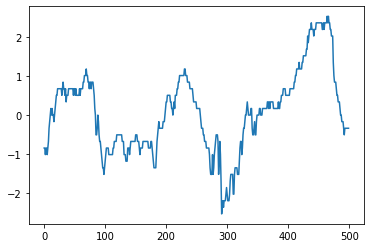

In [12]:
plt.plot(pm25_shanghai[:500])
plt.show()

In [0]:
X_shanghai_train, X_shanghai_test, y_shanghai_train, y_shanghai_test = train_test_split(X_shanghai, y_shanghai)

In [0]:
X_shanghai_train = X_shanghai_train.reshape(X_shanghai_train.shape[0], -1, 1)
X_shanghai_test = X_shanghai_test.reshape(X_shanghai_test.shape[0], -1, 1)

In [0]:
URL_base_model = "https://raw.githubusercontent.com/vishal-pandey/iot-transfer/master/ssim/pm25_beijing_ssim_model.h5"

In [16]:
!wget $URL_base_model

--2020-03-19 08:15:47--  https://raw.githubusercontent.com/vishal-pandey/iot-transfer/master/ssim/pm25_beijing_ssim_model.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2833384 (2.7M) [application/octet-stream]
Saving to: ‘pm25_beijing_ssim_model.h5’

pm25_beijing_ssim_m 100%[===================>]   2.70M  10.3MB/s    in 0.3s    

2020-03-19 08:15:49 (10.3 MB/s) - ‘pm25_beijing_ssim_model.h5’ saved [2833384/2833384]



In [17]:
from keras.models import load_model
model = load_model('pm25_beijing_ssim_model.h5', {'SeqSelfAttention': SeqSelfAttention})












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [18]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 45, 256)           133120    
_________________________________________________________________
seq_self_attention_4 (SeqSel (None, 45, 256)           16449     
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 232,070
Trainable params: 232,070
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(X_shanghai_train, y_shanghai_train, epochs=20, validation_data=(X_shanghai_test, y_shanghai_test))

Train on 416 samples, validate on 139 samples
Epoch 1/20
416/416 [==============================] - 5s 12ms/step - loss: 0.0486 - val_loss: 0.0483
Epoch 2/20
416/416 [==============================] - 2s 6ms/step - loss: 0.0415 - val_loss: 0.0396
Epoch 3/20
416/416 [==============================] - 2s 6ms/step - loss: 0.0336 - val_loss: 0.0382
Epoch 4/20
416/416 [==============================] - 2s 6ms/step - loss: 0.0312 - val_loss: 0.0353
Epoch 5/20
416/416 [==============================] - 2s 6ms/step - loss: 0.0300 - val_loss: 0.0343
Epoch 6/20
416/416 [==============================] - 2s 6ms/step - loss: 0.0289 - val_loss: 0.0327
Epoch 7/20
416/416 [==============================] - 2s 6ms/step - loss: 0.0286 - val_loss: 0.0343
Epoch 8/20
416/416 [==============================] - 2s 6ms/step - loss: 0.0280 - val_loss: 0.0338
Epoch 9/20
416/416 [==============================] - 2s 6ms/step - loss: 0.0276 - val_loss: 0.0323
Epoch 10/20
416/416 [==============================] 

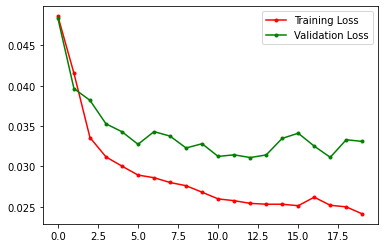

In [20]:
plt.plot(model.history.history['loss'], 'r.-', label="Training Loss")
plt.plot(model.history.history['val_loss'], 'g.-', label="Validation Loss")
plt.legend()
plt.show()

In [0]:
y_hat = model.predict(X_shanghai_test)

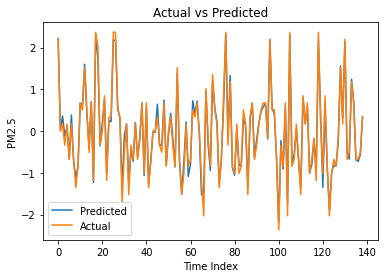

In [22]:
plt.title("Actual vs Predicted")
plt.plot(y_hat[:, 0], label="Predicted")
plt.plot(y_shanghai_test[:, 0], label="Actual")
plt.xlabel("Time Index")
plt.ylabel("PM2.5")
plt.legend()
plt.show()